In [2]:
import pandas as pd

# Load the Wine Quality dataset using the correct delimiter (semicolon)
df = pd.read_csv(r"C:\Users\sonam\Downloads\winequality-red.csv", sep=";")

# Clean column names in case of extra quotes or spaces
df.columns = df.columns.str.replace('"', '').str.strip()

# Verify that the columns are correctly parsed
print("Columns:", df.columns.tolist())




Columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']


We separate the features (X) from the target variable (y) and split the data into training and testing sets to avoid data leakage during the feature selection process

In [3]:
# Clean column names by removing extra quotes and whitespace
df.columns = df.columns.str.replace('"', '').str.strip()

# Separate features and target variable
X = df.drop("quality", axis=1)
y = df["quality"]

# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


a) Forward Selection
Starts with an empty set of features and adds one feature at a time that maximally improves the model’s performance.

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector

# Initialize a linear regression estimator
estimator = LinearRegression()

# Forward selection: start with no features, add one at a time
sfs_forward = SequentialFeatureSelector(estimator, 
                                        n_features_to_select=5, 
                                        direction='forward',
                                        cv=5,
                                        n_jobs=-1)
sfs_forward.fit(X_train, y_train)

# Get selected features
selected_features_forward = X_train.columns[sfs_forward.get_support()]
print("Selected features (Forward Selection):", selected_features_forward.tolist())




Selected features (Forward Selection): ['volatile acidity', 'chlorides', 'total sulfur dioxide', 'sulphates', 'alcohol']


backward selection-Starts with all features and removes one at a time—the least significant feature—until a desired number of features remains.

In [5]:
# Backward elimination: start with all features, remove one at a time
sfs_backward = SequentialFeatureSelector(estimator, 
                                         n_features_to_select=5, 
                                         direction='backward',
                                         cv=5,
                                         n_jobs=-1)
sfs_backward.fit(X_train, y_train)

# Get selected features
selected_features_backward = X_train.columns[sfs_backward.get_support()]
print("Selected features (Backward Elimination):", selected_features_backward.tolist())


Selected features (Backward Elimination): ['volatile acidity', 'chlorides', 'total sulfur dioxide', 'sulphates', 'alcohol']


 Recursive Feature Elimination (RFE)
RFE works by recursively removing the least important feature based on the model’s coefficients until only the desired number of features remains.

In [6]:
from sklearn.feature_selection import RFE

# Initialize RFE with the linear regression estimator to select the top 5 features
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X_train, y_train)

# Extract and print selected features from RFE
selected_features_rfe = X_train.columns[selector.support_]
print("Selected features (RFE):", selected_features_rfe.tolist())


Selected features (RFE): ['volatile acidity', 'chlorides', 'density', 'pH', 'sulphates']


Embedded methods perform feature selection as part of the model training process. In this study, we use LassoCV, which applies L1 regularization to shrink coefficients to zero for less important features.

In [ ]:
from sklearn.linear_model import LassoCV

# Use LassoCV to perform embedded feature selection with cross-validation
lasso = LassoCV(cv=5, random_state=42).fit(X_train, y_train)

# Create a series with feature coefficients
coef = pd.Series(lasso.coef_, index=X_train.columns)

# Select features with non-zero coefficients
selected_features_lasso = coef[coef != 0].index
print("Selected features (LassoCV):", list(selected_features_lasso))



Selected features (LassoCV): ['fixed acidity', 'volatile acidity', 'residual sugar', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates', 'alcohol']


Visualizing the Lasso coefficients can help interpret the relative importance of each feature.

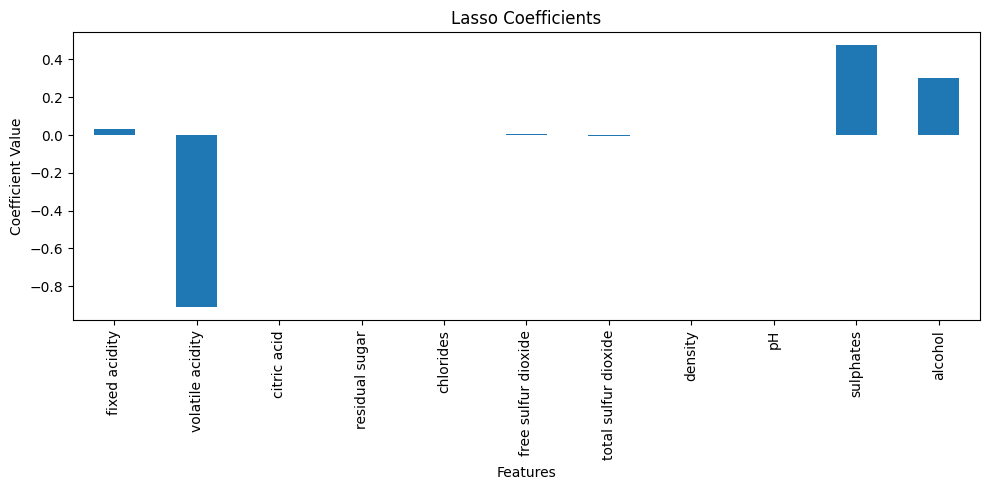

In [ ]:
import matplotlib.pyplot as plt

# Plot the coefficients from the Lasso model
plt.figure(figsize=(10, 5))
coef.plot(kind='bar')
plt.title("Lasso Coefficients")
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.tight_layout()
plt.show()


Inferences<br>
Key Consistent Features:<br>
Across all methods, volatile acidity, chlorides, and sulphates are consistently selected. This reinforces their importance in determining wine quality.

Method-Specific Insights:<br>

Wrapper Methods: Provide a concise and highly interpretable feature set, which is advantageous when model simplicity is desired.<br>
RFE: Its divergence suggests sensitivity to the method of eliminating features based on coefficient stability.<br>
LassoCV: Offers a more nuanced view by retaining additional features with small but non-zero impacts, potentially leading to improved predictive performance when these subtle effects are valuable.<br>
Practical Implication:<br>
The choice of feature selection method should depend on your goals. If you aim for the most interpretable model with a minimal set of features, the consensus from the wrapper methods is compelling. If your priority is to capture all influential signals—even those with modest effects—an embedded method like LassoCV may be preferable.